___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://i.stack.imgur.com/I6hrO.png" width="500px" height="100px" />


# <font color= #8A0829> Repaso Tema 2.</font>

<Strong> Objetivos </Strong>
- Cómo desarrollar un marco genérico de búsqueda en cuadrícula para sintonizar hiperparámetros de modelos.
- Analizar distintos paquetes que ofrecen una visualización y ajuste de hiperparámetros.

> Referencias:
    > - https://medium.com/optuna/using-optuna-to-optimize-tensorflow-hyperparameters-57b6d4d316a2
    > - https://optuna.org/
    > - Capítulo 15 de [Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
___

# Ejemplo de aplicación (conjunto de datos meteorológicos)

Este tutorial utiliza un conjunto de [datos de series temporales meteorológicas](https://www.bgc-jena.mpg.de/wetter/) registrado por el Instituto Max Planck de Biogeoquímica.

Este conjunto de datos contiene 14 características diferentes, como la temperatura del aire, la presión atmosférica y la humedad. Estos se recopilaron cada 10 minutos a partir de 2003. Para mayor eficiencia, utilizará solo los datos recopilados entre 2009 y 2016. Esta sección del conjunto de datos fue preparada por François Chollet para su libro [Aprendizaje profundo con Python](https://www.manning.com/books/deep-learning-with-python).

In [12]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
zip_path

'/Users/user/.keras/datasets/jena_climate_2009_2016.csv.zip'

In [4]:
df = pd.read_csv(csv_path)
df

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
1       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
2       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
3       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
4       01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04   
...                     ...       ...       ...       ...          ...   
420546  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420547  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420548  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420549  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420550  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.11          0.22       1.94   
1        93.40          3.23          3.02          0.21       1.89   
2        93.90          3.21          3.01          0.20       1.88   
3        94.20          3.26          3.07          0.19       1.92   
4        94.10          3.27          3.08          0.19       1.92   
...        ...           ...           ...           ...        ...   
420546   73.10          4.52          3.30          1.22       2.06   
420547   69.71          4.77          3.32          1.44       2.07   
420548   67.91          4.84          3.28          1.55       2.05   
420549   71.80          4.46          3.20          1.26       1.99   
420550   75.70          4.27          3.23          1.04       2.01   

        H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0                  3.12       1307.75      1.03           1.75     152.3  
1                  3.03       1309.80      0.72           1.50     136.1  
2                  3.02       1310.24      0.19           0.63     171.6  
3                  3.08       1309.19      0.34           0.50     198.0  
4                  3.09       1309.00      0.32           0.63     214.3  
...                 ...           ...       ...            ...       ...  
420546             3.30       1292.98      0.67           1.52     240.0  
420547             3.32       1289.44      1.14           1.92     234.3  
420548             3.28       1288.39      1.08           2.00     215.2  
420549             3.20       1293.56      1.49           2.16     225.8  
420550             3.23       1296.38      1.23           1.96     184.9  

[420551 rows x 15 columns]

In [5]:
# Si lo corro por segunda vez, ya no lo descargo nuevamente
df = pd.read_csv('/Users/user/.keras/datasets/jena_climate_2009_2016.csv.zip')
df.head(20)

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0   01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1   01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2   01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3   01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4   01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   
5   01.01.2009 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
6   01.01.2009 01:10:00    996.50     -7.62    265.81        -8.30    94.8   
7   01.01.2009 01:20:00    996.50     -7.62    265.81        -8.36    94.4   
8   01.01.2009 01:30:00    996.50     -7.91    265.52        -8.73    93.8   
9   01.01.2009 01:40:00    996.53     -8.43    264.99        -9.34    93.1   
10  01.01.2009 01:50:00    996.62     -8.76    264.66        -9.66    93.1   
11  01.01.2009 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
12  01.01.2009 02:10:00    996.63     -8.85    264.57        -9.70    93.5   
13  01.01.2009 02:20:00    996.74     -8.83    264.58        -9.68    93.5   
14  01.01.2009 02:30:00    996.81     -8.66    264.74        -9.46    93.9   
15  01.01.2009 02:40:00    996.81     -8.66    264.74        -9.50    93.6   
16  01.01.2009 02:50:00    996.86     -8.70    264.70        -9.55    93.5   
17  01.01.2009 03:00:00    996.84     -8.81    264.59        -9.66    93.5   
18  01.01.2009 03:10:00    996.87     -8.84    264.56        -9.69    93.5   
19  01.01.2009 03:20:00    996.97     -8.94    264.45        -9.82    93.3   

    VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0           3.33          3.11          0.22       1.94             3.12   
1           3.23          3.02          0.21       1.89             3.03   
2           3.21          3.01          0.20       1.88             3.02   
3           3.26          3.07          0.19       1.92             3.08   
4           3.27          3.08          0.19       1.92             3.09   
5           3.33          3.14          0.19       1.96             3.15   
6           3.44          3.26          0.18       2.04             3.27   
7           3.44          3.25          0.19       2.03             3.26   
8           3.36          3.15          0.21       1.97             3.16   
9           3.23          3.00          0.22       1.88             3.02   
10          3.14          2.93          0.22       1.83             2.94   
11          3.12          2.90          0.21       1.81             2.91   
12          3.12          2.92          0.20       1.82             2.93   
13          3.13          2.92          0.20       1.83             2.93   
14          3.17          2.98          0.19       1.86             2.99   
15          3.17          2.97          0.20       1.85             2.98   
16          3.16          2.95          0.21       1.85             2.96   
17          3.13          2.93          0.20       1.83             2.94   
18          3.13          2.92          0.20       1.83             2.93   
19          3.10          2.89          0.21       1.81             2.90   

    rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0        1307.75      1.03           1.75     152.3  
1        1309.80      0.72           1.50     136.1  
2        1310.24      0.19           0.63     171.6  
3        1309.19      0.34           0.50     198.0  
4        1309.00      0.32           0.63     214.3  
5        1307.86      0.21           0.63     192.7  
6        1305.68      0.18           0.63     166.5  
7        1305.69      0.19           0.50     118.6  
8        1307.17      0.28           0.75     188.5  
9        1309.85      0.59           0.88     185.0  
10       1311.64      0.45           0.88     183.2  
11       1312.25      0.25           0.63     190.3  
12       1312.11      0.16           0.50     158.3  
13       1312.15      

In [6]:
# Seleccionar sólo datos cada hora df[init::step]
df =
df

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
5       01.01.2009 01:00:00    996.50     -8.05    265.38        -8.78   
11      01.01.2009 02:00:00    996.62     -8.88    264.54        -9.77   
17      01.01.2009 03:00:00    996.84     -8.81    264.59        -9.66   
23      01.01.2009 04:00:00    996.99     -9.05    264.34       -10.02   
29      01.01.2009 05:00:00    997.46     -9.63    263.72       -10.65   
...                     ...       ...       ...       ...          ...   
420521  31.12.2016 19:10:00   1002.18     -0.98    272.01        -5.36   
420527  31.12.2016 20:10:00   1001.40     -1.40    271.66        -6.84   
420533  31.12.2016 21:10:00   1001.19     -2.75    270.32        -6.90   
420539  31.12.2016 22:10:00   1000.65     -2.89    270.22        -7.15   
420545  31.12.2016 23:10:00   1000.11     -3.93    269.23        -8.09   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
5        94.40          3.33          3.14          0.19       1.96   
11       93.20          3.12          2.90          0.21       1.81   
17       93.50          3.13          2.93          0.20       1.83   
23       92.60          3.07          2.85          0.23       1.78   
29       92.20          2.94          2.71          0.23       1.69   
...        ...           ...           ...           ...        ...   
420521   72.00          5.69          4.09          1.59       2.54   
420527   66.29          5.51          3.65          1.86       2.27   
420533   72.90          4.99          3.64          1.35       2.26   
420539   72.30          4.93          3.57          1.37       2.22   
420545   72.60          4.56          3.31          1.25       2.06   

        H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
5                  3.15       1307.86      0.21           0.63     192.7  
11                 2.91       1312.25      0.25           0.63     190.3  
17                 2.94       1312.18      0.18           0.63     167.2  
23                 2.85       1313.61      0.10           0.38     240.0  
29                 2.71       1317.19      0.40           0.88     157.0  
...                 ...           ...       ...            ...       ...  
420521             4.08       1280.70      0.87           1.36     190.6  
420527             3.65       1281.87      1.02           1.92     225.4  
420533             3.63       1288.02      0.71           1.56     158.7  
420539             3.57       1288.03      0.35           0.68     216.7  
420545             3.31       1292.41      0.56           1.00     202.6  

[70091 rows x 15 columns]

In [7]:
# Poner la fecha como índice y convertirlo a datetime '%d.%m.%Y %H:%M:%S'
df.index =
df.head(10)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
2009-01-01 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
2009-01-01 03:00:00    996.84     -8.81    264.59        -9.66    93.5   
2009-01-01 04:00:00    996.99     -9.05    264.34       -10.02    92.6   
2009-01-01 05:00:00    997.46     -9.63    263.72       -10.65    92.2   
2009-01-01 06:00:00    997.71     -9.67    263.66       -10.62    92.7   
2009-01-01 07:00:00    998.33     -9.17    264.12       -10.10    92.9   
2009-01-01 08:00:00    999.17     -8.10    265.12        -9.05    92.8   
2009-01-01 09:00:00    999.69     -7.66    265.52        -8.84    91.2   
2009-01-01 10:00:00   1000.27     -7.04    266.10        -8.17    91.6   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 01:00:00          3.33          3.14          0.19       1.96   
2009-01-01 02:00:00          3.12          2.90          0.21       1.81   
2009-01-01 03:00:00          3.13          2.93          0.20       1.83   
2009-01-01 04:00:00          3.07          2.85          0.23       1.78   
2009-01-01 05:00:00          2.94          2.71          0.23       1.69   
2009-01-01 06:00:00          2.93          2.71          0.21       1.69   
2009-01-01 07:00:00          3.04          2.83          0.22       1.76   
2009-01-01 08:00:00          3.31          3.07          0.24       1.92   
2009-01-01 09:00:00          3.43          3.13          0.30       1.95   
2009-01-01 10:00:00          3.60          3.30          0.30       2.05   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 01:00:00             3.15       1307.86      0.21           0.63   
2009-01-01 02:00:00             2.91       1312.25      0.25           0.63   
2009-01-01 03:00:00             2.94       1312.18      0.18           0.63   
2009-01-01 04:00:00             2.85       1313.61      0.10           0.38   
2009-01-01 05:00:00             2.71       1317.19      0.40           0.88   
2009-01-01 06:00:00             2.72       1317.71      0.05           0.50   
2009-01-01 07:00:00             2.83       1315.98      2.08           2.88   
2009-01-01 08:00:00             3.08       1311.65      0.72           1.25   
2009-01-01 09:00:00             3.13       1310.14      0.34           0.63   
2009-01-01 10:00:00             3.29       1307.76      1.45           3.00   

                     wd (deg)  
Date Time                      
2009-01-01 01:00:00     192.7  
2009-01-01 02:00:00     190.3  
2009-01-01 03:00:00     167.2  
2009-01-01 04:00:00     240.0  
2009-01-01 05:00:00     157.0  
2009-01-01 06:00:00     146.0  
2009-01-01 07:00:00     348.8  
2009-01-01 08:00:00     213.9  
2009-01-01 09:00:00     202.2  
2009-01-01 10:00:00     292.6

## 1. Preparación y análisis exploratorio de datos de salida

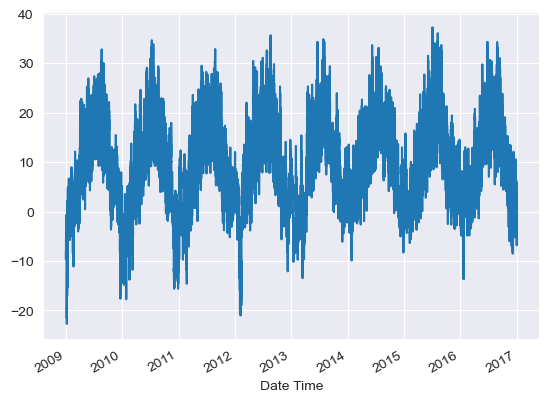

In [20]:
temp = df['T (degC)']
temp.plot()
plt.show()

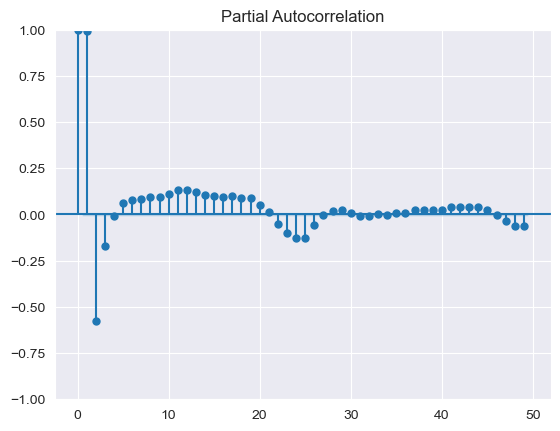

In [23]:
# Gráficas de PACF y ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_pacf(temp);

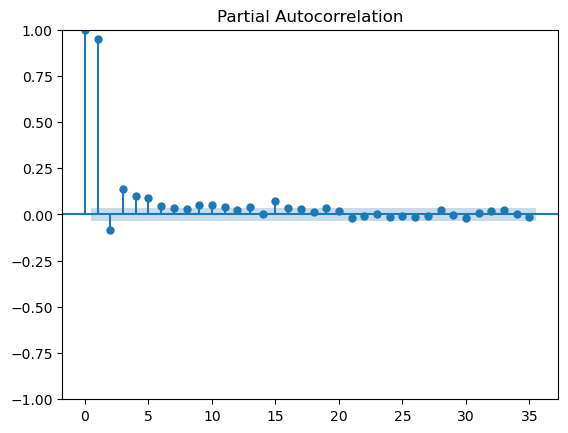

In [39]:
# Que sucede si analizo por día
plot_pacf(df.resample('d').sum()['T (degC)']);

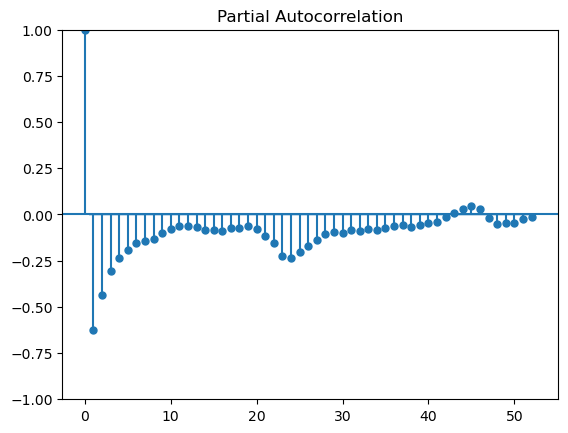

In [41]:
# Que obtengo si diferencio
plot_pacf(temp.diff().diff().diff().dropna(), **{'lags': 52});

### - Eliminación de outliers

En general, la eliminación de outliers puede ser adecuada si los valores atípicos son muy extremos o son el resultado de errores en los datos, como mediciones incorrectas o errores de entrada. Si estos valores no son representativos de la población subyacente o no son necesarios para lograr el objetivo del modelo, entonces eliminarlos puede mejorar la calidad del modelo.

Sin embargo, si los valores atípicos son importantes para el modelo, ya sea porque representan eventos raros, pero importantes o porque son una característica importante de la serie de tiempo, entonces reemplazarlos por algún valor estadístico puede ser una mejor opción. Por ejemplo, en algunos casos puede ser adecuado reemplazar los valores atípicos con el promedio o la mediana de los valores cercanos para evitar que afecten demasiado el modelo

**En este caso, como los valores atípicos que tenemos no son muy extremos vamos a modelarlos inicialmente como valores atípicos y luego veremos si es necesario reemplazarlos por algún valor estadístico.**

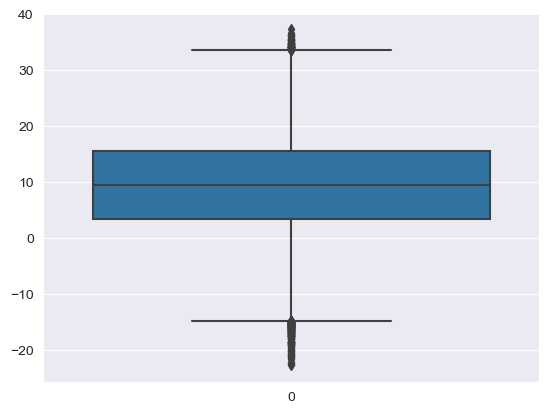

In [8]:
# Presencia de outliers
sns.boxplot(temp)
plt.show()

In [36]:
# Función para eliminar outliers en caso de ser necesario
def remove_outliers(df: pd.DataFrame, column: str):
    """
    Remove outliers from a dataframe
    :param df: Dataframe to remove outliers.
    :param column: Column to remove outliers
    :return: Dataframe without outliers
    """
    df = df.copy()
    q1, q3 = np.percentile(df[column], [25, 75])
    iqr = q3 - q1
    ub = 1.5 * iqr + q3
    lb = q1 - 1.5 * iqr
    df = df[(df[column] <= ub) & (df[column] >= lb)]
    print(ub, lb)
    return df

### - Definir datos de entrenamiento, validación y test

Vamos a tomar un 80% de los datos para entrenamiento, un 10% para validación y un 10% para test.

In [ ]:
# Datos de entrenamiento
train = temp[:int(len(temp) * 0.8)]
# Datos de validación
val = temp[int(len(temp) * 0.8):int(len(temp) * 0.9)]
# Datos de test
test = temp[int(len(temp) * 0.9):]

### - Normalización de datos

In [55]:
# import standard scaler y transformar la variable train
from sklearn.preprocessing import StandardScaler

scaler_temp = StandardScaler()
train = scaler_temp.fit_transform(train.values.reshape(-1, 1))
val = scaler_temp.transform(val.values.reshape(-1, 1))
test = scaler_temp.transform(test.values.reshape(-1, 1))

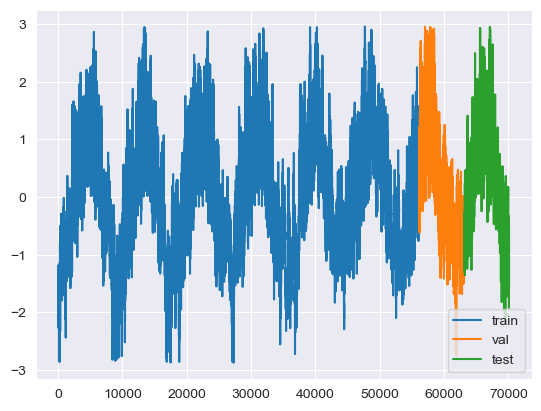

In [56]:
# Graficar en una sola gráfica los datos de entrenamiento, validación y test de la variable T (degC) de mi dataset
import matplotlib.pyplot as plt

plt.plot(temp.index[:len(train)], train, label='train')
plt.plot(temp.index[len(train):len(train) + len(val)], val, label='val')
plt.plot(temp.index[len(train) + len(val):], test, label='test')
plt.legend()
plt.show()

### - Ahora podemos convertir nuestros datos a un problema supervisado.

In [46]:
def series_to_supervised(data, n_in, n_out=1):
    if not isinstance(data, pd.DataFrame):
        df = pd.DataFrame(data)
    else:
        df = data.copy()

    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))

    # put it all together
    agg = pd.concat(cols, axis=1)

    # drop rows with NaN values
    agg.dropna(inplace=True)

    agg = agg.values

    X, y = agg[:, :-1], agg[:, -1]

    # Convertir valores a forma tensorial
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], 1))
    return X, y

In [57]:
n_steps = 24
X_train, y_train = series_to_supervised(train, n_steps)
X_val, y_val = series_to_supervised(val, n_steps)
X_test, y_test = series_to_supervised(test, n_steps)

# Imprimir dimensiones de los datos de entrenamiento, validación y test
print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (55838, 24, 1) (55838, 1)
Datos de validación (6959, 24, 1) (6959, 1)
Datos de test (6959, 24, 1) (6959, 1)


## Modelado

### 1.1 Definir modelo CNN

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
import keras
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [73]:
# Definimos nuestro modelo
# Se define el número de pasos de tiempo de entrada (n_steps) y el número de características (n_features)
n_features = 1
n_steps = 24

# Definimos el modelo
model_1 = Sequential()
model_1.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_1.add(MaxPooling1D())
model_1.add(Flatten())
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(1))

model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    # metrics=['mape']
)
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 23, 64)            192       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 704)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                35250     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 35,493
Trainable params: 35,493
Non-trainable params: 0
__________________________________________________

<AxesSubplot: >

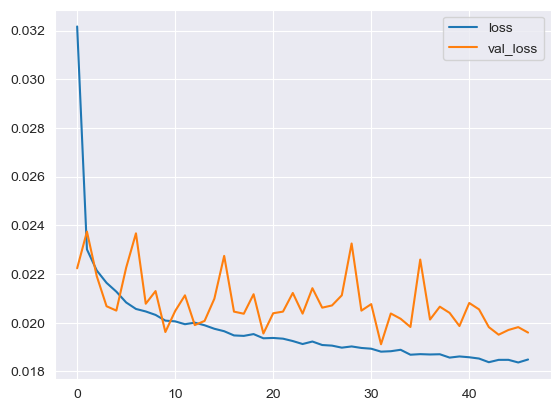

In [74]:
# Guardamos el mejor modelo cuando se obtenga la menor pérdida
cnn_cp = ModelCheckpoint('models/model_1_cnn.h5', monitor='loss', save_best_only=True, verbose=0)

cnn_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15)

# Ajustamos el modelo anterior
history_1 = model_1.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    verbose=False,
    callbacks=[cnn_earlystop, cnn_cp]
)

pd.DataFrame(history_1.history).plot()

## - Predicciones en el conjunto de test

218/218 [==============================] - 0s 928us/step


<AxesSubplot: >

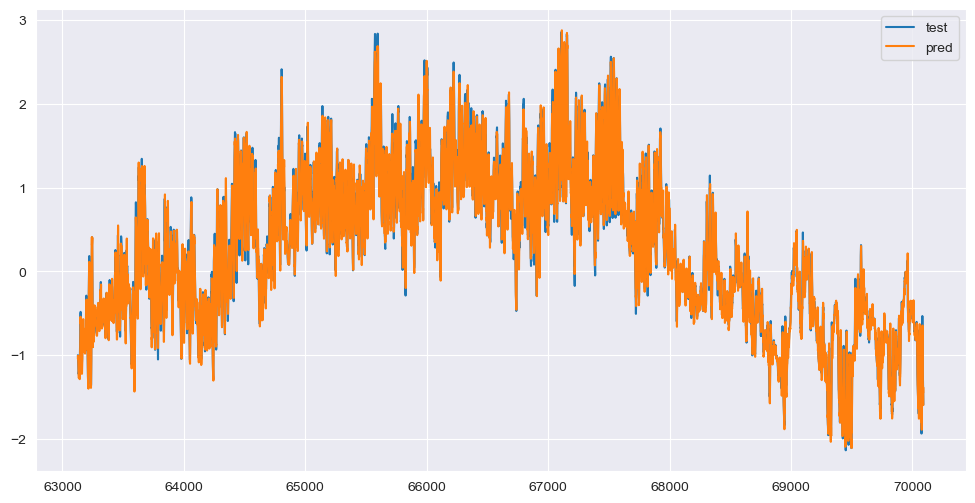

In [76]:
# Generar predicciones
y_pred = model_1.predict(X_test)

# Crear dataframe con los datos de test y las predicciones
df_pred = pd.DataFrame({'test': y_test.flatten(), 'pred': y_pred.flatten()}, index=temp.index[-len(y_test):])

# Invertir la normalización
df_pred[['test', 'pred']] = scaler_temp.inverse_transform(df_pred[['test', 'pred']])

# Graficar los resultados
df_pred.plot(figsize=(12, 6))

<AxesSubplot: >

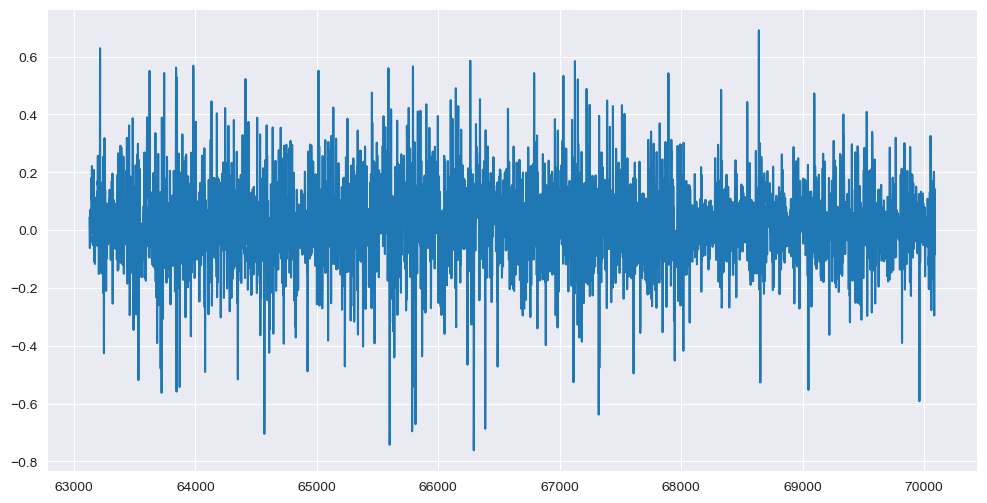

In [77]:
# Graficar el error de estimación
df_pred['error'] = df_pred['test'] - df_pred['pred']
df_pred['error'].plot(figsize=(12, 6))

## - Predicciones en el conjunto de validación

218/218 [==============================] - 0s 1ms/step


<AxesSubplot: >

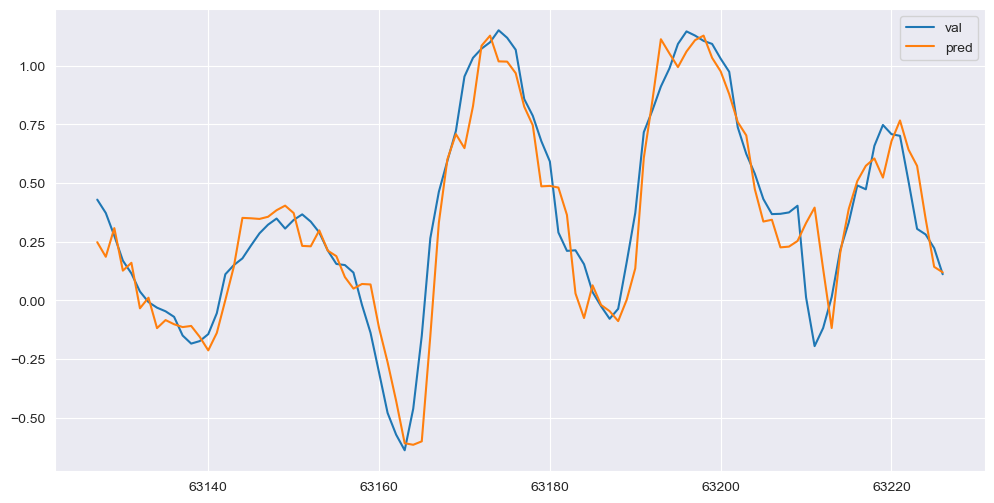

In [82]:
# Usemos los datos de validación para hacer predicciones
y_pred_val = model_1.predict(X_val)

# Crear dataframe con los datos de validación y las predicciones
df_pred_val = pd.DataFrame({'val': y_val.flatten(), 'pred': y_pred_val.flatten()}, index=temp.index[-len(y_val):])

# Invertir la normalización
df_pred_val[['val', 'pred']] = scaler_temp.inverse_transform(df_pred_val[['val', 'pred']])

# Graficar los resultados
df_pred_val[:100].plot(figsize=(12, 6))

## - Predicciones en el conjunto de entrenamiento

1745/1745 [==============================] - 2s 903us/step


<AxesSubplot: >

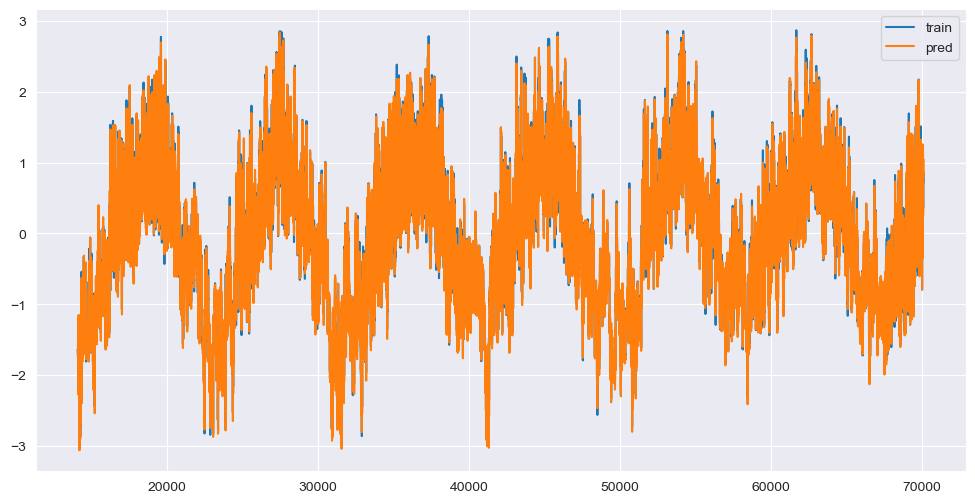

In [84]:
# Usemos los datos de entrenamiento para hacer predicciones
y_pred_train = model_1.predict(X_train)

# Crear dataframe con los datos de entrenamiento y las predicciones
df_pred_train = pd.DataFrame({'train': y_train.flatten(), 'pred': y_pred_train.flatten()},
                             index=temp.index[-len(y_train):])

# Invertir la normalización
df_pred_train[['train', 'pred']] = scaler_temp.inverse_transform(df_pred_train[['train', 'pred']])

# Graficar los resultados
df_pred_train.plot(figsize=(12, 6))

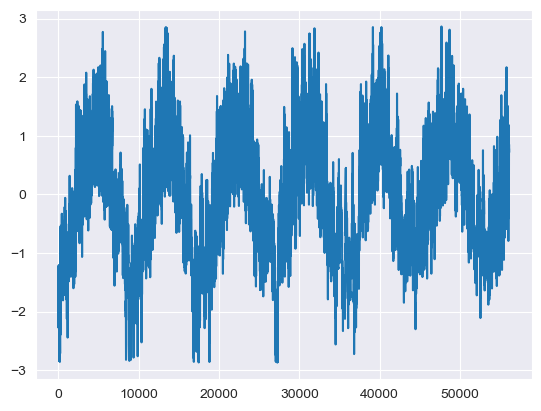

In [86]:
# Graficar la serie de tiempo original en su escala original para los datos de entrenamiento
plt.plot(temp.index[:len(train)], temp[:len(train)])

Usaremos el modelo que obtuvo la menor pérdida en el conjunto de entrenamiento para hacer predicciones en el conjunto de test.

218/218 [==============================] - 0s 960us/step


<AxesSubplot: >

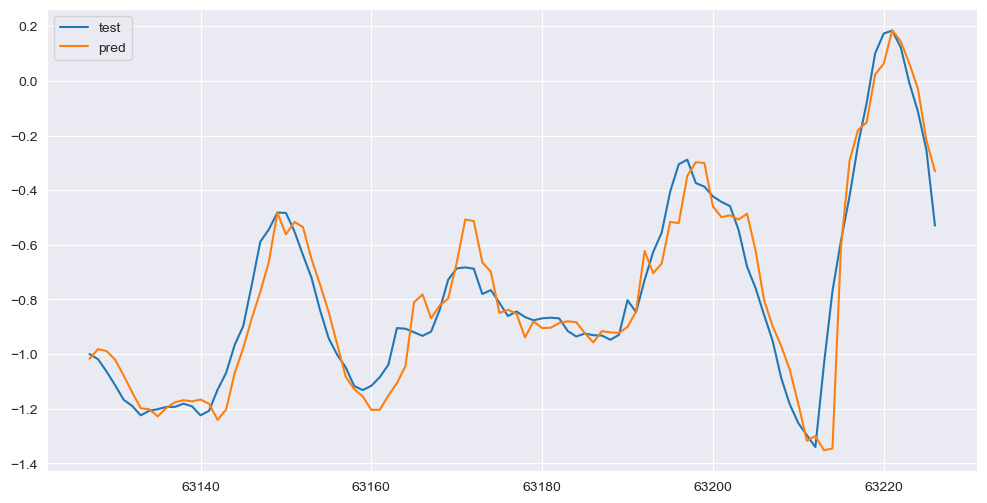

In [80]:
# Cargar el mejor modelo
model_load1 = keras.models.load_model('models/model_1_cnn.h5')

# Generar predicciones
y_pred = model_load1.predict(X_test)

# Crear dataframe con los datos de test y las predicciones
df_pred = pd.DataFrame({'test': y_test.flatten(), 'pred': y_pred.flatten()}, index=temp.index[-len(y_test):])

# Invertir la normalización
df_pred[['test', 'pred']] = scaler_temp.inverse_transform(df_pred[['test', 'pred']])

# Graficar los resultados
df_pred[:100].plot(figsize=(12, 6))

### 1.2 Optimización de hiperparámetros con optuna

In [87]:
import optuna

In [90]:
def objective(trial):
    # Definimos el número de pasos de tiempo de entrada (n_steps) y el número de características (n_features)
    n_features = 1
    n_steps = 24

    # Definimos el modelo
    model = Sequential()
    model.add(Conv1D(
        filters=trial.suggest_int('filters', 32, 128),
        kernel_size=2,
        activation='relu',
        input_shape=(n_steps, n_features))
    )
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(
        units=trial.suggest_int('units', 64, 256),
        activation='relu')
    )
    model.add(keras.layers.Dropout(
        trial.suggest_float('dropout', 0.1, 0.5)
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1)),
        loss='mse',
        # metrics=['mape']
    )

    # Guardamos el mejor modelo cuando se obtenga la menor pérdida
    # cnn_cp = ModelCheckpoint('models/model_2_cnn_optuna.h5', monitor='loss', save_best_only=True, verbose=0)

    cnn_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)

    # Ajustamos el modelo anterior
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=trial.suggest_int('epochs', 100, 700),
        verbose=False,
        callbacks=[cnn_earlystop]  #, cnn_cp]
    )

    return history.history['val_loss'][-1]

In [91]:
# Definir el objeto de estudio de Optuna y ejecutar la búsqueda de hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Imprimir los resultados
print('Best trial:', study.best_trial.params)
print('Best mse:', study.best_trial.value)

[I 2023-03-23 14:33:11,083] A new study created in memory with name: no-name-55f58215-318a-46c3-b466-07f53fb52ad3
[I 2023-03-23 14:34:05,255] Trial 0 finished with value: 1.014966368675232 and parameters: {'filters': 78, 'units': 197, 'dropout': 0.3332235600722434, 'learning_rate': 0.08519878079205516, 'epochs': 256}. Best is trial 0 with value: 1.014966368675232.
[I 2023-03-23 14:35:08,532] Trial 1 finished with value: 0.03038732334971428 and parameters: {'filters': 103, 'units': 106, 'dropout': 0.26960600847763, 'learning_rate': 0.015639668118004983, 'epochs': 552}. Best is trial 1 with value: 0.03038732334971428.
[I 2023-03-23 14:36:25,844] Trial 2 finished with value: 0.08829974383115768 and parameters: {'filters': 123, 'units': 239, 'dropout': 0.259945445805857, 'learning_rate': 0.08308446670104165, 'epochs': 680}. Best is trial 1 with value: 0.03038732334971428.
[I 2023-03-23 14:37:21,343] Trial 3 finished with value: 0.03634287789463997 and parameters: {'filters': 76, 'units': 1

Best trial: {'filters': 40, 'units': 247, 'dropout': 0.12353164596013891, 'learning_rate': 0.01397511740315342, 'epochs': 597}
Best mse: 0.027211826294660568


In [99]:
def create_cnn_model(params):
    # Definimos el número de pasos de tiempo de entrada (n_steps) y el número de características (n_features)
    n_features = 1
    n_steps = 24

    # Definimos el modelo
    model = Sequential()
    model.add(Conv1D(
        filters=params['filters'],
        kernel_size=2,
        activation='relu',
        input_shape=(n_steps, n_features))
    )
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(
        units=params['units'],
        activation='relu')
    )
    model.add(keras.layers.Dropout(
        params['dropout']
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        # metrics=['mape']
    )

    # Guardamos el mejor modelo cuando se obtenga la menor pérdida
    cnn_cp = ModelCheckpoint('models/model_2_cnn_optuna.h5', monitor='loss', save_best_only=True, verbose=0)

    cnn_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)

    # Ajustamos el modelo anterior
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        verbose=False,
        callbacks=[cnn_cp, cnn_earlystop]
    )

    pd.DataFrame(history.history).plot(figsize=(12, 6))

    return model

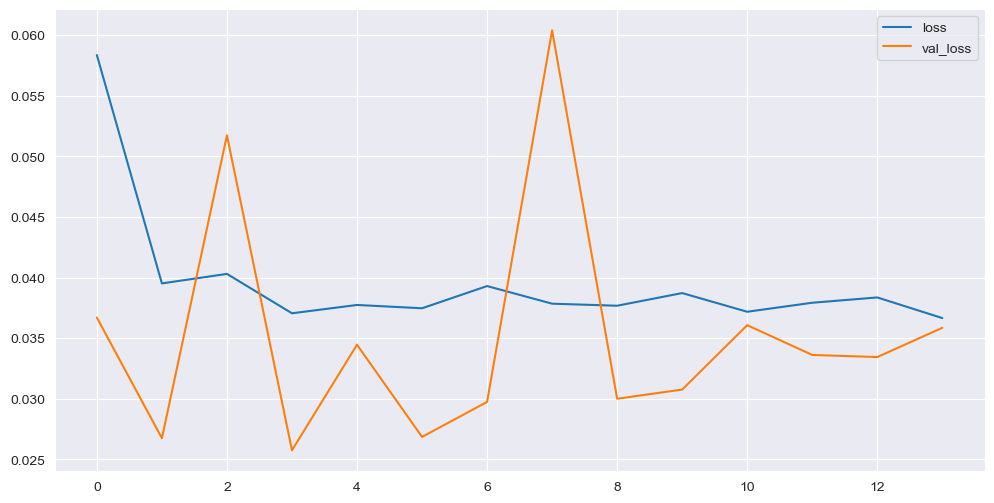

In [100]:
# Mejor modelo encontrado con optuna
best_model_cnn = create_cnn_model(study.best_trial.params)

Además de la función `plot_optimization_history`, Optuna proporciona otras herramientas para visualizar el proceso de optimización. Algunas de ellas son:

- `optuna.visualization.plot_slice`: Esta función muestra una gráfica de dispersión en 2D para cada par de parámetros. Esto puede ayudar a visualizar cómo los valores de los parámetros afectan el valor objetivo.

- `optuna.visualization.plot_contour`: Esta función muestra una gráfica de contorno en 2D para cada par de parámetros. Esto puede ayudar a visualizar cómo los valores de los parámetros interactúan entre sí y cómo afectan el valor objetivo.

- `optuna.visualization.plot_parallel_coordinate`: Esta función muestra una gráfica de coordenadas paralelas que permite visualizar cómo los valores de todos los parámetros afectan el valor objetivo.

In [129]:
optuna.visualization.plot_slice(study)

In [130]:
optuna.visualization.plot_contour(study)

In [131]:
optuna.visualization.plot_parallel_coordinate(study)

In [132]:
optuna.visualization.plot_optimization_history(study)

## 1.3 Definir el modelo LSTM
...


## 1.4 Definir el modelo MLP
...

## Caso multivariado para predecir la temperatura

**Nota:**
Crear características derivadas de una serie de tiempo es una práctica común en el análisis de series de tiempo. Algunas de las características más usuales son las características de tiempo, como el día de la semana, el mes, el trimestre, el año, etc. En particular, las características que implican funciones trigonométricas como el seno o el coseno son comunes debido a que las series de tiempo a menudo muestran patrones estacionales o cíclicos que pueden ser modelados utilizando estas funciones.

La idea detrás de estas características es capturar patrones periódicos en la serie de tiempo, que pueden ser difíciles de modelar con otras características. Por ejemplo, una serie de tiempo que muestra una fuerte estacionalidad semanal puede tener patrones distintos en los fines de semana en comparación con los días laborables. Al crear una característica que representa el día de la semana como una variable categórica, se pierde información sobre la periodicidad semanal. Al agregar características que representan el día de la semana como funciones trigonométricas (seno o coseno), se pueden capturar patrones periódicos, como una serie de tiempo que aumenta en las mañanas y disminuye en las noches durante los días laborables.

En resumen, crear características que implican funciones trigonométricas como el seno o el coseno pueden ser útiles para capturar patrones periódicos en una serie de tiempo, que son difíciles de modelar con otras características. Al hacerlo, se pueden mejorar las capacidades predictivas de los modelos de pronóstico de series de tiempo.

In [121]:
# Vamos a crear una nueva columna con la temperatura en grados Celsius
temp_df = temp.copy().to_frame()

temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)

temp_df

T (degC)       Seconds
Date Time                                  
2009-01-01 01:00:00     -8.05  1.230772e+09
2009-01-01 02:00:00     -8.88  1.230775e+09
2009-01-01 03:00:00     -8.81  1.230779e+09
2009-01-01 04:00:00     -9.05  1.230782e+09
2009-01-01 05:00:00     -9.63  1.230786e+09
...                       ...           ...
2016-12-31 19:10:00     -0.98  1.483211e+09
2016-12-31 20:10:00     -1.40  1.483215e+09
2016-12-31 21:10:00     -2.75  1.483219e+09
2016-12-31 22:10:00     -2.89  1.483222e+09
2016-12-31 23:10:00     -3.93  1.483226e+09

[70091 rows x 2 columns]

<AxesSubplot: xlabel='Date Time'>

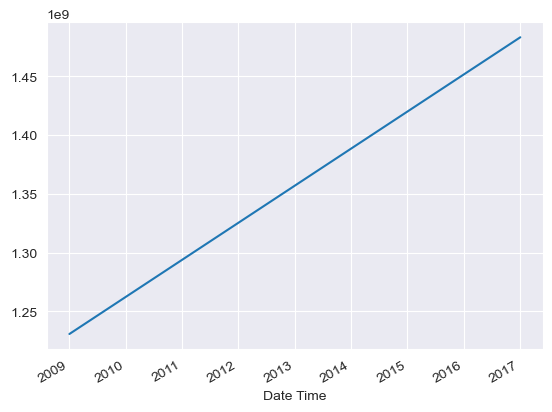

In [122]:
temp_df['Seconds'].plot()

# Significado de pd.Timestamp.timestamp

Cuenta la cantidad de segundos desde el 1 de enero de 1970 hasta la fecha indicada. Por ejemplo, el 1 de enero de 1970 a las 00:00:00 es 0, el 1 de enero de 1970 a las 00:00:01 es 1, el 1 de enero de 1970 a las 00:00:02 es 2, etc.

In [123]:
day = 60 * 60 * 24
year = 365.2425 * day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

T (degC)       Seconds   Day sin   Day cos  Year sin  \
Date Time                                                                   
2009-01-01 01:00:00     -8.05  1.230772e+09  0.258819  0.965926  0.010049   
2009-01-01 02:00:00     -8.88  1.230775e+09  0.500000  0.866025  0.010766   
2009-01-01 03:00:00     -8.81  1.230779e+09  0.707107  0.707107  0.011483   
2009-01-01 04:00:00     -9.05  1.230782e+09  0.866025  0.500000  0.012199   
2009-01-01 05:00:00     -9.63  1.230786e+09  0.965926  0.258819  0.012916   

                     Year cos  
Date Time                      
2009-01-01 01:00:00  0.999950  
2009-01-01 02:00:00  0.999942  
2009-01-01 03:00:00  0.999934  
2009-01-01 04:00:00  0.999926  
2009-01-01 05:00:00  0.999917

array([<AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>], dtype=object)

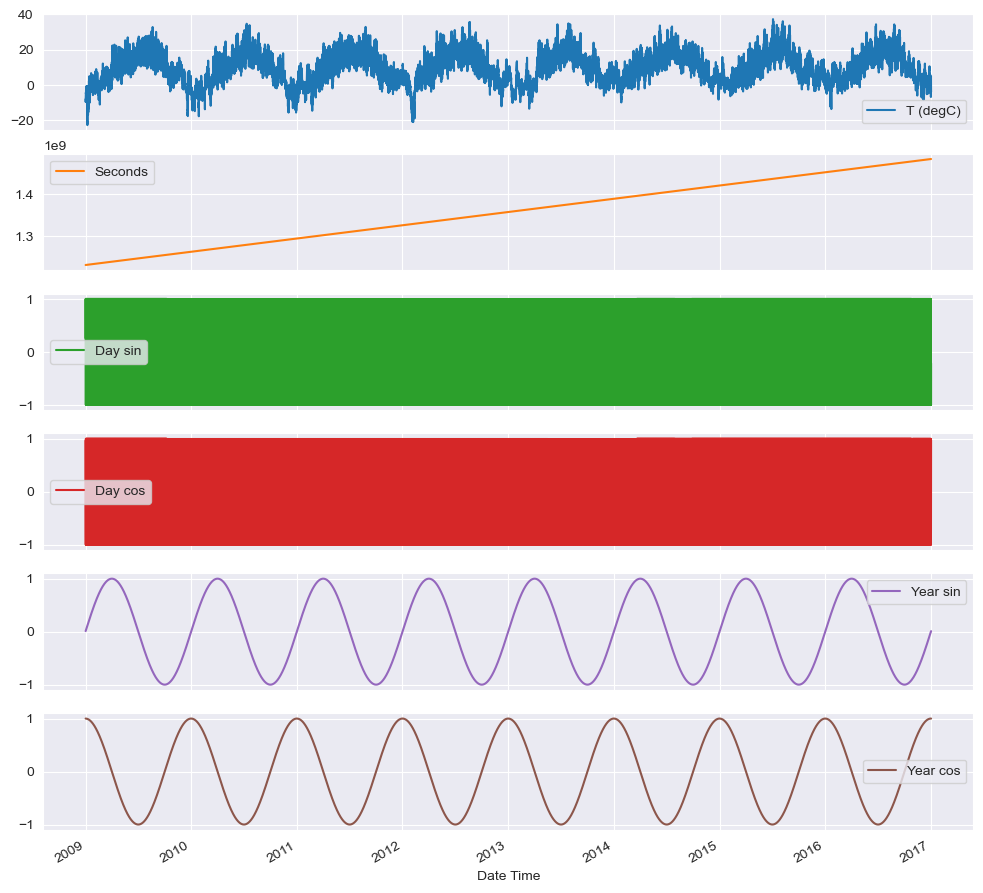

In [127]:
temp_df[:].plot(subplots=True, figsize=(12, 12))

In [128]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

T (degC)   Day sin   Day cos  Year sin  Year cos
Date Time                                                            
2009-01-01 01:00:00     -8.05  0.258819  0.965926  0.010049  0.999950
2009-01-01 02:00:00     -8.88  0.500000  0.866025  0.010766  0.999942
2009-01-01 03:00:00     -8.81  0.707107  0.707107  0.011483  0.999934
2009-01-01 04:00:00     -9.05  0.866025  0.500000  0.012199  0.999926
2009-01-01 05:00:00     -9.63  0.965926  0.258819  0.012916  0.999917

In [138]:
# También podemos crear características derivadas de una serie de tiempo
# Crear características derivadas de una serie de tiempo
def create_time_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear
    df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
    return df

In [137]:
# Columna objetivo al final
order_columns = ['Day sin', 'Day cos', 'Year sin', 'Year cos', 'T (degC)']
temp_df = temp_df[order_columns]

In [170]:
# dividir en conjuntos de entrenamiento y prueba

# Datos de entrenamiento
train = temp_df.iloc[:int(len(temp_df) * 0.8), :]
# Datos de validación
val = temp_df.iloc[int(len(temp_df) * 0.8):int(len(temp_df) * 0.9), :]
# Datos de test
test = temp_df.iloc[int(len(temp_df) * 0.9):, :]

train.shape


(56072, 5)

array([<AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>], dtype=object)

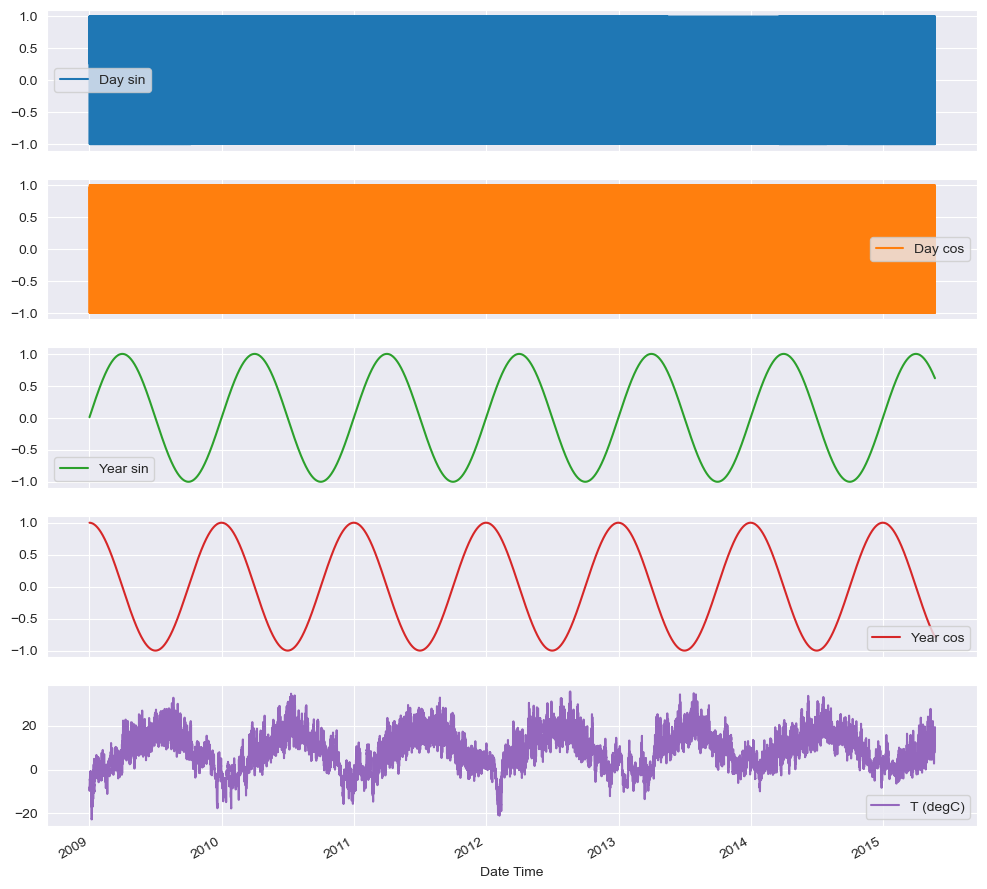

In [173]:
train.plot(subplots=True, figsize=(12, 12))

In [174]:
train.mean()

Day sin    -0.000013
Day cos    -0.000278
Year sin    0.045255
Year cos    0.014866
T (degC)    8.987746
dtype: float64

array([<AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>], dtype=object)

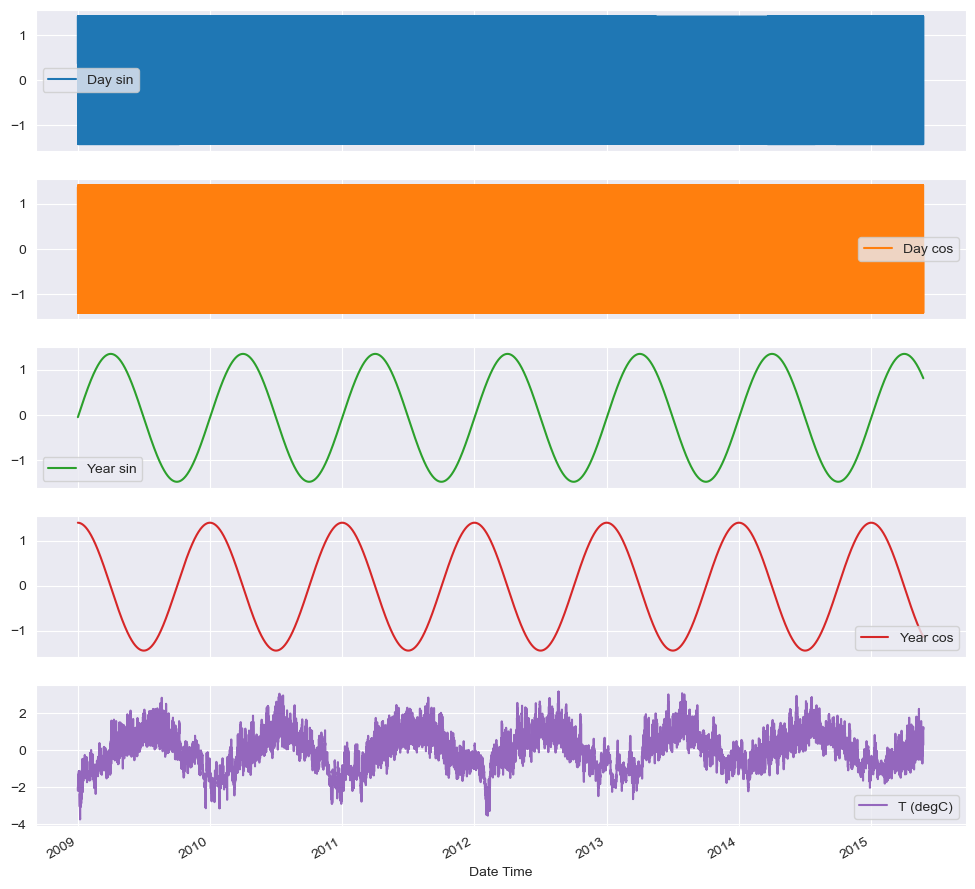

In [175]:
mean, std = train.mean(), train.std()
train = (train - mean) / std
val = (val - mean) / std
test = (test - mean) / std

train.plot(subplots=True, figsize=(12, 12))

In [177]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step(sequence: np.ndarray, n_steps_in: int, n_steps_out: int=1):
    """
    Divide una secuencia multivariada en muestras
    :param sequence: Array de numpy con la secuencia
    :param n_steps_in: Número de pasos de entrada
    :param n_steps_out: Número de pasos de salida
    :return: Devuelve dos arrays de numpy con las muestras de entrada y salida
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 6, 1

X_train, y_train = split_multivariate_sequence_m_step(train.values, n_steps_in, n_steps_out)

In [198]:
n_steps_in, n_steps_out = 6, 1

X_train, y_train = split_multivariate_sequence_m_step(train.values, n_steps_in, n_steps_out)
X_val, y_val = split_multivariate_sequence_m_step(val.values, n_steps_in, n_steps_out)
X_test, y_test = split_multivariate_sequence_m_step(test.values, n_steps_in, n_steps_out)

# Imprimir dimensiones de los datos de entrenamiento, validación y test
print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (56067, 6, 4) (56067, 1)
Datos de validación (7004, 6, 4) (7004, 1)
Datos de test (7005, 6, 4) (7005, 1)


In [199]:
n_features = 4

# Crear el modelo de TensorFlow
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 6, 32)             4736      
                                                                 
 dropout_22 (Dropout)        (None, 6, 32)             0         
                                                                 
 lstm_8 (LSTM)               (None, 6, 32)             8320      
                                                                 
 dropout_23 (Dropout)        (None, 6, 32)             0         
                                                                 
 dense_47 (Dense)            (None, 6, 1)              33        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [200]:
LSTM_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[LSTM_earlystop], verbose=0)


<AxesSubplot: >

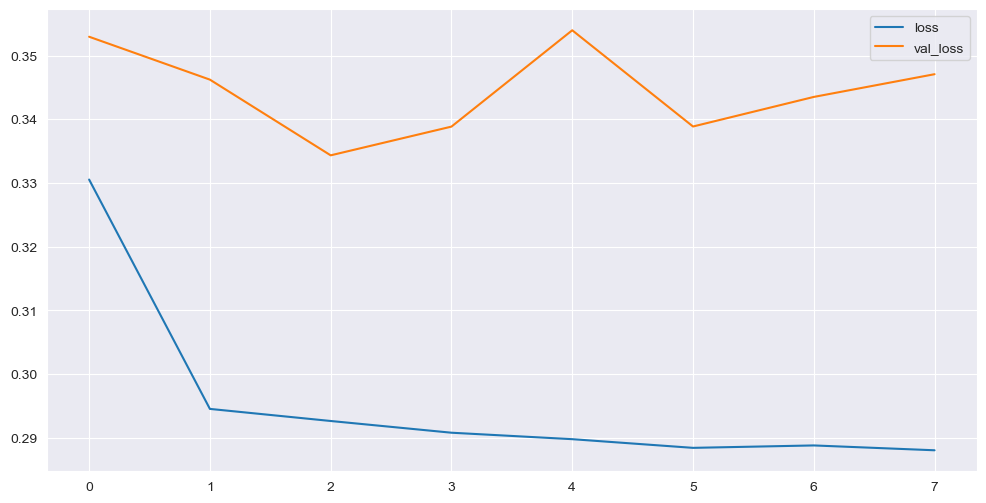

In [201]:
# Graficar la pérdida del modelo
pd.DataFrame(history.history).plot(figsize=(12, 6))

In [202]:
# Generar predicciones
y_pred = model.predict(X_test)

# Crear dataframe con los datos de test y las predicciones
df_pred = pd.DataFrame({'test': y_test.flatten(), 'pred': y_pred.flatten()}, index=temp.index[-len(y_test):])

# Invertir la normalización
df_pred[['test', 'pred']] = (df_pred[['test', 'pred']]) * std + mean

# Graficar los resultados
df_pred.plot(figsize=(12, 6))

219/219 [==============================] - 2s 3ms/step


ValueError: Length of values (42030) does not match length of index (7005)

In [193]:
X_test.shape, y_test.shape, y_pred.shape

((7005, 6, 4), (7005, 1), (7005, 6, 1))

In [197]:
y_test, y_pred

(array([[-0.83612821],
        [-0.84442108],
        [-0.86100682],
        ...,
        [-1.39056583],
        [-1.40715157],
        [-1.53035993]]),
 array([[[-0.83428615],
         [-0.8198487 ],
         [-0.7876399 ],
         [-0.7606835 ],
         [-0.7471308 ],
         [-0.7442259 ]],
 
        [[-0.86878544],
         [-0.85852534],
         [-0.83101857],
         [-0.80736834],
         [-0.7958653 ],
         [-0.7927375 ]],
 
        [[-0.89820534],
         [-0.89429444],
         [-0.8737417 ],
         [-0.8541472 ],
         [-0.84442073],
         [-0.8401959 ]],
 
        ...,
 
        [[-1.0405703 ],
         [-1.0362562 ],
         [-0.98526293],
         [-0.9623094 ],
         [-0.9573224 ],
         [-0.95694476]],
 
        [[-1.054526  ],
         [-1.0483948 ],
         [-0.9980988 ],
         [-0.9766258 ],
         [-0.9718527 ],
         [-0.9706946 ]],
 
        [[-1.0644065 ],
         [-1.0576557 ],
         [-1.0096442 ],
         [-0.99006516],
 

## Optimización de hiperparámetros con Optuna

In [ ]:
import pandas as pd
import tensorflow as tf
import optuna


def objective(trial):
    # Definir los hiperparámetros a ajustar
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    num_neurons = trial.suggest_int('num_neurons', 16, 256, log=True)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Crear el modelo de TensorFlow
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=num_neurons, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    for i in range(num_hidden_layers - 1):
        model.add(tf.keras.layers.LSTM(units=num_neurons, return_sequences=True))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.LSTM(units=num_neurons))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))

    # Compilar el modelo con los hiperparámetros ajustados
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')

    # Entrenar el modelo y obtener el error de validación
    history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, batch_size=16, verbose=0)
    val_loss = history.history['val_loss'][-1]

    return val_loss


# Definir los parámetros de la red neuronal
n_steps = 7
n_features = 1

# Definir el objeto de estudio de Optuna y ejecutar la búsqueda de hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados
print('Best trial:', study.best_trial.params)
print('Best validation loss:', study.best_trial.value)


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>